# TP5 - NLP Job Description in the US Dataset

Mục đích của TP này : dự đoán cột target là career level của vị trí tuyển dụng thông qua các cột features khác của một job description

In [1]:
# Check the directory now where i'm working
import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\KTANG\Downloads\Python\Learn DS\TPs\TP5 - NLP


### Importing library


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTEN
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### B1 : Data collection : phải đi làm mới có (bỏ qua)
### Bước Importing data

In [ ]:
df = pd.read_excel("JD_US.ods", engine="odf", dtype=str)
df

,title,location,description,function,industry,career_level
0,Technical Professional Lead - Process,"Houston, TX","Responsible for the study, design, and specifi...",production_manufacturing,Machinery and Industrial Facilities Engineering,senior_specialist_or_project_manager
1,Cnslt - Systems Eng- Midrange 1,"Seattle, WA","Participates in design, development and implem...",information_technology_telecommunications,Financial Services,senior_specialist_or_project_manager
2,SharePoint Developers and Solution Architects,"Dallas, TX",We are currently in need of Developers who can...,consulting,IT Consulting,senior_specialist_or_project_manager
3,Business Information Services - Strategic Acco...,North Carolina,Experian is seeking an experienced Account Exe...,sales,"Security, Risk, Restructuring Consulting",senior_specialist_or_project_manager
4,Strategic Development Director (procurement),"Austin, TX",Â Want to join a world-class global procuremen...,procurement_materials_logistics,Information Technology,bereichsleiter
...,...,...,...,...,...,...
8069,Sales Engineer,"Waltham, MA",You are the primary technical resource for the...,sales,Hardware,senior_specialist_or_project_manager
8070,"Director of Sales, ClosetMaid","Atlanta, GA",Act as the primary contact for Home Depot deci...,sales,Furniture,senior_specialist_or_project_manager
8071,PROPERTY MANAGEMENT: Regional Vice President,"Los Angeles, CA","Responsible for the management of office, mult...",finance_accounting,Real Estate Investment Companies,manager_team_leader
8072,Technical Manager SAP Senior,New York,Viseo Business Solution Practice invested in S...,consulting,IT Consulting,senior_specialist_or_project_manager


In [4]:
# Thay thế giá trị "bereichsleiter" thành "head_division" để dễ hiểu
df["career_level"] = df["career_level"].replace("bereichsleiter", "head_division")
df

,title,location,description,function,industry,career_level
0,Technical Professional Lead - Process,"Houston, TX","Responsible for the study, design, and specifi...",production_manufacturing,Machinery and Industrial Facilities Engineering,senior_specialist_or_project_manager
1,Cnslt - Systems Eng- Midrange 1,"Seattle, WA","Participates in design, development and implem...",information_technology_telecommunications,Financial Services,senior_specialist_or_project_manager
2,SharePoint Developers and Solution Architects,"Dallas, TX",We are currently in need of Developers who can...,consulting,IT Consulting,senior_specialist_or_project_manager
3,Business Information Services - Strategic Acco...,North Carolina,Experian is seeking an experienced Account Exe...,sales,"Security, Risk, Restructuring Consulting",senior_specialist_or_project_manager
4,Strategic Development Director (procurement),"Austin, TX",Â Want to join a world-class global procuremen...,procurement_materials_logistics,Information Technology,head_division
...,...,...,...,...,...,...
8069,Sales Engineer,"Waltham, MA",You are the primary technical resource for the...,sales,Hardware,senior_specialist_or_project_manager
8070,"Director of Sales, ClosetMaid","Atlanta, GA",Act as the primary contact for Home Depot deci...,sales,Furniture,senior_specialist_or_project_manager
8071,PROPERTY MANAGEMENT: Regional Vice President,"Los Angeles, CA","Responsible for the management of office, mult...",finance_accounting,Real Estate Investment Companies,manager_team_leader
8072,Technical Manager SAP Senior,New York,Viseo Business Solution Practice invested in S...,consulting,IT Consulting,senior_specialist_or_project_manager


In [5]:
df.info(); df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8074 entries, 0 to 8073
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         8074 non-null   object
 1   location      8074 non-null   object
 2   description   8073 non-null   object
 3   function      8074 non-null   object
 4   industry      8074 non-null   object
 5   career_level  8074 non-null   object
dtypes: object(6)
memory usage: 378.6+ KB


,title,location,description,function,industry,career_level
count,8074,8074,8073,8074,8074,8074
unique,6790,1081,7973,19,352,6
top,Account Manager,"New York City, NY",Practice Medicine in Northern California with ...,sales,Software Companies,senior_specialist_or_project_manager
freq,58,401,5,3151,688,4338


Vì cột "description" có đúng một hàng bị NULL, ta không cần fill mà drop hàng đó luôn

In [6]:
df = df.dropna(axis=0, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8073 entries, 0 to 8073
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         8073 non-null   object
 1   location      8073 non-null   object
 2   description   8073 non-null   object
 3   function      8073 non-null   object
 4   industry      8073 non-null   object
 5   career_level  8073 non-null   object
dtypes: object(6)
memory usage: 441.5+ KB


### Bước chỉnh sửa cột "location"

<ins>Mục đích :</ins> để đến bước tiền xử lý văn bản ta sẽ xử lý nhẹ nhàng hơn (nếu không thì sẽ gặp vấn đề như khi làm OneHot bên dưới), khi đó ta sẽ sử dụng các thuật toán TF-IDF hoặc OneHot để chuyển đổi văn bản.

<ins>Vấn đề sau OneHot :</ins>
- Có tận 963 cột được tạo ra sau khi dùng OneHotEncoder, quá nhiều và gây khó khăn cho việc xử lý dữ liệu. Nên ta lập luận rằng để dự đoán career level thì các thành phố trong cùng bang sẽ như nhau, nên ta không cần biết thông tin về từng thành phố, mà chỉ cần biết thông tin về tiểu bang thôi

<ins>Hướng làm để tách các giá trị tiểu bang của từng hàng :</ins>
- Cột nay có dữ liệu không sạch, giá trị tiểu bang có thể sau dấu phẩy hoặc không, có thể viết tắt hoặc không, nên ta sẽ sử dụng **RegEx** để tách chúng một cách tốt nhất
- Sử dụng các trang regex trên mạng để test các parameter của **RegEx** cần dùng
- Viết một hàm để tìm và trả về các giá trị của tiểu bang trong mỗi hàng vào một list => Dùng **findall** trong thư viên `re`

<ins>Cách làm :</ins>
- Viết hàm `filter_state` để tách các giá trị tiểu bang trong mỗi hàng ngay sau bước Importing Data

<ins>Kết quả :</ins>

- Sau khi dùng function **filter_state** trước khi dùng **OneHotEncoder**, đã giảm cột xuống còn 95 cột thành vì 963 cột, rất hợp lý và dễ dàng xử lý hơn

In [7]:
def filter_state(location_value):
    state = re.findall("\,\s[A-Z]{2}$", location_value)
    if len(state) > 0:
        return state[0][2:4]
    else:
        return location_value

<>:2: SyntaxWarning: invalid escape sequence '\,'
<>:2: SyntaxWarning: invalid escape sequence '\,'
C:\Users\KTANG\AppData\Local\Temp\ipykernel_12516\1869176104.py:2: SyntaxWarning: invalid escape sequence '\,'
  state = re.findall("\,\s[A-Z]{2}$", location_value)


Dùng hàm `apply()` để áp dụng function ``filter_state vào từng hàng của cột dữ liệu (Giải thích phía dưới ở phần làm feature thứ hai "location")

In [8]:
df["location"] = df["location"].apply(filter_state)

C:\Users\KTANG\AppData\Local\Temp\ipykernel_12516\3792979346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["location"] = df["location"].apply(filter_state)


### Bước chia dữ liệu (trước bước tiền xử lý dữ liệu):

Là bước chia dữ liệu theo :
- Phần A: theo chiều dọc (theo cột), tức là chia các cột X (các cột feature) với cột Y (cột target)
- Phần B: theo chiều ngang, tức là chia datasets thành 3 dataset con gồm bộ train, bộ validation và bộ test theo tỷ lệ tùy chọn (8-1-1, 9-0.5-0.5, 6-2-2)


Phần A

In [9]:
# Xác định target
target = "career_level"

x = df.drop(target, axis=1)
y = df[target]

Phần B

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42, stratify=y)

print(f" Shape of train set is {x_train.shape} on x and {y_train.shape} on y")
print(f" Shape of test set is {x_test.shape} on x and {y_test.shape} on y")
print("\n")
print(f"- Nb of samples of train set is \n{y_test.value_counts()} \n\n- And of test set is \n{y_train.value_counts()}")

# ---------- Balanced Samplinng (Ở đây ta dùng Over Sampling) (Chỉ dùng bước này áp dụng vào bộ train chứ không áp dụng cho bộ test) ----------
# - RandomOverSampler : phương thức này sẽ giúp mô hình gặp các dữ liệu THƯỜNG XUYÊN HƠN CHỨ KHÔNG ĐA DẠNG HƠN
# - SMOTE : phương thức này sẽ giúp mô hình tạo ra những dữ liệu mới CHIA SẺ ĐẶC ĐIỂM NHƯNG KHÔNG GIỐNG DỮ LIỆU CŨ, chỉ dành cho tập dữ liệu số
# - SMOTENC : tương tự SMOTE, chỉ dành cho tập dữ liệu có ít nhất một feature số
# - SMOTENC : tương tự SMOTE, chỉ dành cho tập dữ liệu chuỗi

oversampling = SMOTEN(random_state=42, k_neighbors=2)
x_train_os_non_strategy, y_train_os_non_strategy = oversampling.fit_resample(x_train, y_train)


print("\n")
print(f"- Nb of samples of train set AFTER OVER SAMPLING W/OUT STRATEGY is \n{y_train_os_non_strategy.value_counts()}")

# ---------- Vấn đề của Over Sampling : TẠO RA QUÁ NHIỀU BIẾN MỚI CHO CLASS THIỂU SỐ TRONG CỘT TARGET CỦA BỘ TRAIN ----------
# - Thuật toán Balanced Data, gọi là cân bằng dữ liệu, nhưng thật ra bản chất là giúp dữ liệu **đỡ mất cân bằng** thôi và **nó chỉ được thực hiện trên bộ dữ liệu train**
# - Với bài toán phân loại, khi phân chia ra các bộ train, validation, test, ta phải đảm bảo rằng phân bố của cả ba bộ này là như nhau. Nhưng nếu dùng Over Sampling 
#   thì sẽ không thể đảm bảo được điều này và làm mất phân bố ban đầu của bộ data mà ta làm. 
# => Đây là một sự đánh đổi, dùng Over Sampling (hoặc Under Sampling) sẽ làm mất cân bằng và phân phối ban đầu của bộ dữ liệu nhưng sẽ giúp tăng độ chính xác của mô hình nhờ 
#    việc mô hình được gặp các class thiểu số nhiều hơn. Vậy để cân bằng giữa việc tăng độ chính xác và giữ nguyên phân bố ban đầu của dữ liệu thì ta có thể sử dụng parameter **sampling_strategy** 
#    để chỉ ra với mỗi class ta muốn tăng lên/giảm xuống đến bao nhiêu mẫu (không nhắc đến nghĩa là không tăng/giảm).

oversampling = SMOTEN(random_state=42, k_neighbors=2, sampling_strategy={
    "head_division" : 1000,
    "director_business_unit_leader" : 500,
    "specialist" : 500,
    "managing_director_small_medium_company" : 500
})
x_train_os_with_strategy, y_train_os_with_strategy = oversampling.fit_resample(x_train, y_train)
print("\n")
print(f"- Nb of samples of train set AFTER OVER SAMPLING W/ STRATEGY is \n{y_train_os_with_strategy.value_counts()}")


 Shape of train set is (6458, 5) on x and (6458,) on y
 Shape of test set is (1615, 5) on x and (1615,) on y


- Nb of samples of train set is 
career_level
senior_specialist_or_project_manager      868
manager_team_leader                       534
head_division                             192
director_business_unit_leader              14
specialist                                  6
managing_director_small_medium_company      1
Name: count, dtype: int64 

- And of test set is 
career_level
senior_specialist_or_project_manager      3469
manager_team_leader                       2138
head_division                              768
director_business_unit_leader               56
specialist                                  24
managing_director_small_medium_company       3
Name: count, dtype: int64


- Nb of samples of train set AFTER OVER SAMPLING W/OUT STRATEGY is 
career_level
manager_team_leader                       3469
senior_specialist_or_project_manager      3469
head_division      

<ins>Lưu ý :</ins> Khi nghĩ đến việc tối ưu mô hình, ta có thể sẽ nghĩ đến việc gộp các class thiểu số lại thành một class lớn hơn. Tuy nhiên, điều này có thể dẫn đến việc mất đi các đặc điểm quan trọng của từng class nhỏ. Đặc biệt, nếu các class trong target có thứ tự hoặc có ý nghĩa cụ thể, việc gộp các class cần được xem xét kĩ (**Hierarchical Classification**).

- Ví dụ : có 5 size XS, S, M, L, XL, nếu muốn tối ưu mô hình khi class XS và XL là các class thiểu số, ta có thể nghĩ đến việc gộp hia class này nhưng điều này có thể dẫn đến việc mất đi các đặc điểm quan trọng của hai size đó.
- Ở đây, các career level có thứ tự `specialist < senior_specialist_or_project_manager < manager_team_leader < head_division < director_business_unit_leader < managing_director_small_medium_company` nên nếu muốn thì chỉ có thể gộp `director_business_unit_leader` và `director_business_unit_leader` nhưng không gộp chung `specialist` được

In [11]:
# Thay thế x_train và y_train bằng các biến của bộ train set mới vừa tạo

# x_train, y_train = x_train_os_with_strategy, y_train_os_with_strategy
# x_train, y_train = x_train_os_non_strategy, y_train_os_non_strategy

### Bước  tiền xử lý dữ liệu chuỗi string:

![Text Preprocessing](../Text_preprocessing.png)

<ins>*Lúc nào dùng TF-IDF, lúc nào dùng OneHot :*</ins> Kiểm tra số lượng giá trị riêng biệt trong một cột, nếu nó ít hơn 100 thì dùng OneHotEncoder, nếu nó nhiều hơn thì dùng TF-IDF

<ins>*Cách làm :*</ins> Sử dụng thẳng `ColumnTransformer` để biến đổi tuần tự 5 cột features gồm `title`, `location`, `description`, `function`, `industry` (ở đây không dùng **Pipeline** nữa vì trong NLP không cần bước Imputation chuẩn như trong ML Supervised hay Unsupervised, do đó chỉ còn một bước xử lý nên không cần dùng **Pipeline** nữa) 

<ins>*Lưu ý :*</ins> Khi sử dụng `TfidfVectorizer` trong `ColumnTransformer`, ta không được gộp tất cả các cột vào một `TfidfVectorizer` mà phải gán riêng cho từng bước cho từng cột (mặc định, nếu không sẽ lỗi), trong khi OneHot Encoder thì có thể gộp tất cả các cột vào một bước (tuy nhiên ở đây tôi vẫn tách ra để cho dễ nhìn và dễ apply các bước khác vào từng cột về sau).

In [12]:
# Kiểm tra các giá trị riêng biệt của từng feature để quyết định xem nên áp dụng TF- IDF hay One Hot Encoding vào feature đó 
# Nhắc lại : >100 giá trị riêng biệt thì dùng TF-IDF, =<100 thì dùng One Hot Encoding

for col in x_train.columns:
    num_unique = df[col].nunique() # Tính số giá trị riêng biệt của mỗi feature, giống len(df[col].unique())
    if num_unique > 100:
        print(f"- {col} has {num_unique} unique value → Must use TF-IDF")
    else:
        print(f"- {col} has {num_unique} unique value → Must use One Hot Encoding")

- title has 6789 unique value → Must use TF-IDF
- location has 97 unique value → Must use One Hot Encoding
- description has 7973 unique value → Must use TF-IDF
- function has 19 unique value → Must use One Hot Encoding
- industry has 352 unique value → Must use TF-IDF


In [ ]:
# Nhắc lại : Khi làm bước ColumnTransformer này thì khi khai biến tên cột áp dụng cho các thuật toán, riêng TfidfVectorizer sẽ ko xài ngoặc vuông "[]" 
# vì quy định mỗi TfidfVectorizer chỉ được áp dụng cho 1 cột,
# còn One Hot Encoding thì vẫn xài bình thường dù có chỉ là một biến hay nhiều biến.

# Riêng trong phần xử lý cột "description", thêm hai biên "min_df" và "max_df" vì sau ktra thì riêng cột này sau mã hóa có tới hơn 800000 cột
# và nó có thể gây ra nhiễu khi huấn luyện mô hình và lmaf giảm hiệu suất, nên ta đặt hai cận để loại bỏ các từ gây nhiễu mà 
# ko đem lại giá trị cho mô hình huấn luyện. Cụ thể :
# min_df: bỏ từ xuất hiện quá ít (từ hiếm, lỗi chính tả) => ko có ý nghĩa => ta chọn ở dây là dưới 1%
# max_df: bỏ từ quá phổ biến (từ chung như "the", "is") => ko có ý nghĩa huấn luyện để dự đoán => ta chọn ở dây là trên 99%

text_preprocessor = ColumnTransformer(transformers=[ 
    ("title_col", TfidfVectorizer(stop_words="english", ngram_range=(1,1)), "title"),
    ("location_col", OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=5), ["location"]),
    ("description_col", TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=0.01, max_df=0.99), "description"), 
    ("function_col", OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=5), ["function"]),
    ("industry_col", TfidfVectorizer(stop_words="english", ngram_range=(1,1)), "industry")])

text_preprocessor 




ColumnTransformer(transformers=[('title_col',
                                 TfidfVectorizer(stop_words='english'),
                                 'title'),
                                ('location_col',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               min_frequency=5,
                                               sparse_output=False),
                                 ['location']),
                                ('description_col',
                                 TfidfVectorizer(max_df=0.99, min_df=0.01,
                                                 ngram_range=(1, 2),
                                                 stop_words='english'),
                                 'description'),
                                ('function_col',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               min_frequency=5,
                                               sparse_output=False),
                                 ['function']),
                                ('industry_col',
                                 TfidfVectorizer(stop_words='english'),
                                 'industry')])

In [ ]:
step_preprocessing = Pipeline(steps= [
    ("preprocessor", text_preprocessor),
    ("feature_selector", SelectKBest(chi2, k=800)) # SelectKBest dùng khi đã biết trước số feature, nếu ko biết, dùng SelectPercentile để giữ lại số lượng % features tốt nhất
    # ("feature_selector", SelectPercentile(chi2, percentile=5))
])

processed_data = step_preprocessing.fit_transform(x_train, y_train)
processed_data.shape

(6458, 800)

### Bước 5: Chọn mô hình

Ta chọn **MÔ HÌNH PHI TUYẾN** như `RandomForestClassifier`



In [15]:
model = Pipeline(steps= [
    ("preprocessor", text_preprocessor),
    # ("feature_seleciton", SelectKBest(chi2, k=800)),
    ("feature_selector", SelectPercentile(chi2, percentile=5)),
    ("classifier", RandomForestClassifier(random_state=42))
])

params = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split" : [2, 5],
    "feature_selector__percentile": [1, 5, 10]
}

scores = {
    'precision_macro': 'precision_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'roc_auc_ovr': 'roc_auc_ovr',
    'roc_auc_ovo': 'roc_auc_ovo'
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, cv=2, 
                           scoring=scores, refit = 'roc_auc_ovr', 
                           n_jobs=-1, verbose=2, 
                           error_score='raise') # error_score='raise' nghĩa là nếu trong quá trình chạy model và tìm kiếm không tìm thấy giá trị nào thì sẽ raise lỗi


Ta cho máy học và dự đoán dựa trên model1 bởi GridSearchCV

In [16]:
grid_search.fit(x_train, y_train);

Fitting 2 folds for each of 216 candidates, totalling 432 fits


Vì tôi đã sử dụng **multi-metrics scoring** để cho vào parameter scoring nên giờ tôi phải in ra các bộ metrics kèm performance tốt nhất để chọn, default tôi đã để **refit = roc_auc_ovr** nếu có metric nào tốt hơn thì sẽ thay

In [17]:
import pandas as pd

# Giả sử bạn đã fit xong GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Lấy các cột scoring
score_cols = sorted([col for col in results.columns if col.startswith('mean_test_')])

# Tìm index tốt nhất của từng metric
best_indices = {col: results[col].idxmax() for col in score_cols}

# Tạo bảng tóm tắt các metric tốt nhất và params tương ứng
summary_rows = []

for col in score_cols:
    idx = best_indices[col]
    summary_rows.append({
        'metric': col.replace('mean_test_', ''),
        'score': results[col][idx],
        'params': results['params'][idx]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by='score', ascending=False)

# In ra bảng kết quả
print(summary_df)


               metric     score  \
4         roc_auc_ovr  0.914991   
3         roc_auc_ovo  0.848123   
1  precision_weighted  0.756670   
2     recall_weighted  0.752090   
0     precision_macro  0.562141   

                                              params  
4  {'classifier__criterion': 'gini', 'classifier_...  
3  {'classifier__criterion': 'entropy', 'classifi...  
1  {'classifier__criterion': 'gini', 'classifier_...  
2  {'classifier__criterion': 'gini', 'classifier_...  
0  {'classifier__criterion': 'gini', 'classifier_...  


In [18]:
# Vì GridSearchCV dựa trên nguyên lý Cross-validation nên đây là các điểm dựa trên bộ VALIDATION
print(grid_search.best_estimator_)

print(grid_search.best_params_)
print(grid_search.best_score_) # đây là điểm dựa trên thông số tốt nhất trên bộ VALIDATION
print(grid_search.best_index_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('title_col',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'title'),
                                                 ('location_col',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=5,
                                                                sparse_output=False),
                                                  ['location']),
                                                 ('description_col',
                                                  TfidfVectorizer(max_df=0.99,
                                                                  min_df=0.01,
                                                                  ngram_range=(1,
                                              

#### Thư viện pickle :
thư viện dùng để save và load mọi thứ

In [19]:
filename = "model_nlp.pkl"
pickle.dump(grid_search, open("model_nlp.pkl", "wb"))


### Bước 6: Đánh giá mô hình

Để coi lý thuyết về hàm predict(), coi TP1 Bước 6




In [20]:
# Ví dụ bây giờ không train nữa mà load thôi
model_from_pickle = pickle.load(open('model_nlp.pkl','rb'))

y_predict = model_from_pickle.predict(x_test)

6.2) Dùng các metrics : ở đây trong bài toán classification, ta có các metric như accuracy, f1 ,...

Trong bài toán multiclass classification, khi bạn dùng các hàm `f1_score, precision_score, recall_score` thì có 1 số lưu ý quan trọng để tránh lỗi, đặc biệt là với f1_score, precision_score và recall_score vì chúng cần biết cách tổng hợp (averaging) các lớp lại với nhau bằng cách thêm parameter `average='các giá trị bên dưới'` vào các hàm này. Ví dụ :

| `average`    | Ý nghĩa                                                                |
| ------------ | ---------------------------------------------------------------------- |
| `'micro'`    | Gộp tất cả các nhãn lại rồi tính tổng số TP/FP/FN                      |
| `'macro'`    | Tính riêng F1 (hoặc Precision/Recall) cho từng lớp, rồi lấy trung bình (coi như trọng số của các features là như nhau) |
| `'weighted'` | Như macro, nhưng tính trung bình có trọng số theo số mẫu của từng lớp  |
| `'samples'`  | Dùng cho multilabel — không dùng trong multiclass                      |

Dùng 'macro' nếu bạn muốn mỗi lớp có trọng số như nhau

Dùng 'weighted' nếu bạn muốn cân nhắc lớp nào có nhiều mẫu hơn


In [21]:
print(f"Điểm Accuracy của cả tập test set là : {accuracy_score(y_test, y_predict)}")
print(f"Điểm Precision của cả tập test set là  : {precision_score(y_test, y_predict, average='weighted')}")
print(f"Điểm Recall của cả tập test set là : {recall_score(y_test, y_predict, average='weighted')}")
print(f"Điểm F1 của cả tập test set là: {f1_score(y_test, y_predict, average='weighted')}")


Điểm Accuracy của cả tập test set là : 0.7479876160990712
Điểm Precision của cả tập test set là  : 0.7429221153670384
Điểm Recall của cả tập test set là : 0.7479876160990712
Điểm F1 của cả tập test set là: 0.7096447186761787


c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
print(f"Report is : \n {classification_report(y_test, y_predict)}")

# Sáu  dòng đầu là điểm cho từng class cụ thể, ba dòng sau là điểm cho cả tập dataset

Report is : 
                                         precision    recall  f1-score   support

         director_business_unit_leader       1.00      0.14      0.25        14
                         head_division       0.70      0.07      0.13       192
                   manager_team_leader       0.63      0.74      0.68       534
managing_director_small_medium_company       0.00      0.00      0.00         1
  senior_specialist_or_project_manager       0.82      0.92      0.87       868
                            specialist       0.00      0.00      0.00         6

                              accuracy                           0.75      1615
                             macro avg       0.53      0.31      0.32      1615
                          weighted avg       0.74      0.75      0.71      1615



c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KTANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

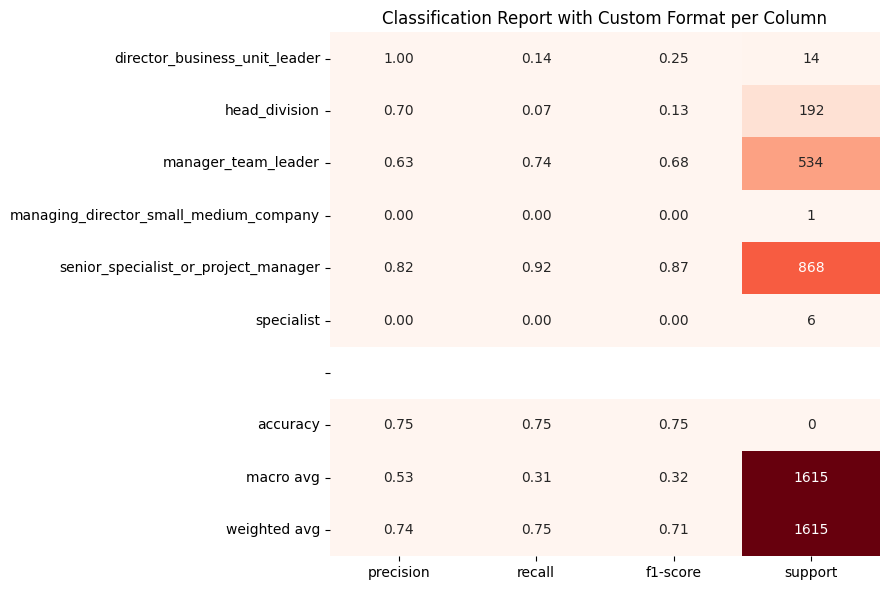

In [23]:
report = classification_report(y_test, y_predict, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report['support'] = df_report['support'].astype(int)
blank_row = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=[''], columns=['precision', 'recall', 'f1-score', 'support'])
summary_labels = ['accuracy', 'macro avg', 'weighted avg']
class_labels = [idx for idx in df_report.index if idx not in summary_labels and idx != '']
df_plot = pd.concat([
    df_report.loc[class_labels],
    blank_row,
    df_report.loc[summary_labels]
])

# Tạo ma trận chuỗi định dạng riêng biệt cho từng cột
annot = df_plot.copy().astype(str)

for row in annot.index:
    for col in annot.columns:
        val = df_plot.loc[row, col]
        if pd.isna(val):
            annot.loc[row, col] = ''
        elif col == 'support':
            annot.loc[row, col] = f"{val:.0f}"  # không có thập phân
        else:
            annot.loc[row, col] = f"{val:.2f}"  # 2 chữ số thập phân

# Vẽ heatmap với chuỗi định dạng riêng
plt.figure(figsize=(9, 6))
sns.heatmap(df_plot, annot=annot.values, fmt="", cmap="Reds", cbar=False)
plt.title("Classification Report with Custom Format per Column")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Sáu dòng đầu là điểm cho từng class cự thể, ba dòng sau là điểm cho cả tập dataset

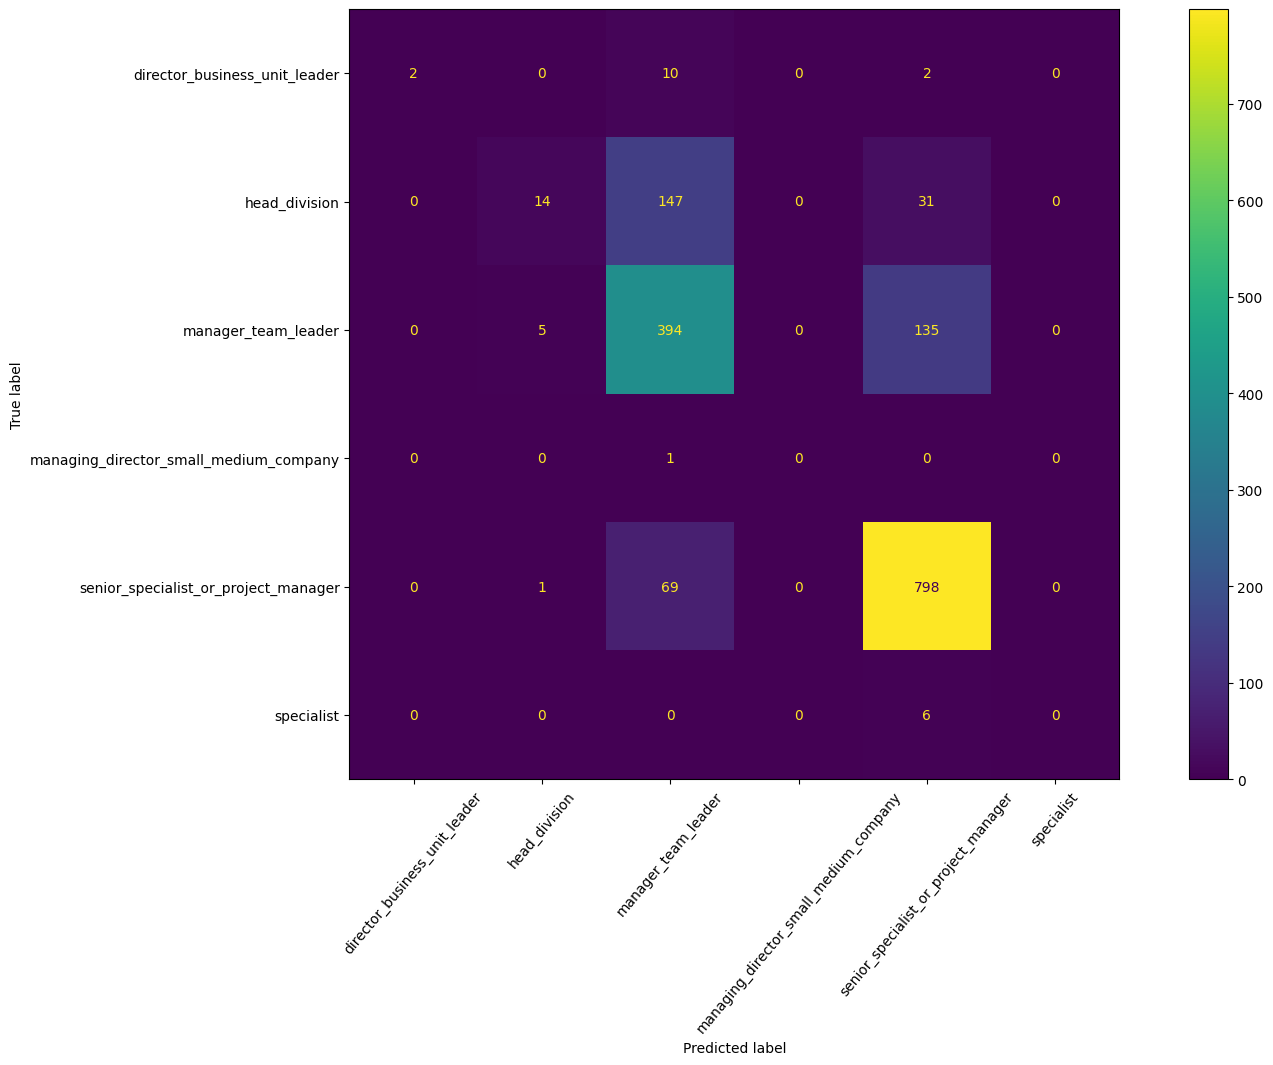

In [26]:
cm = confusion_matrix(y_test, y_predict, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)

fig, ax = plt.subplots(figsize=(18, 10))  
disp.plot(ax=ax, xticks_rotation=50);


Chạy nhanh các mô hình khác để so sánh hiệu suất

In [31]:
applied_step_preprocessing_to_features = Pipeline(steps= [
    ("preprocessor", text_preprocessor)
])

x_train_for_training = applied_step_preprocessing_to_features.fit_transform(x_train)
x_test_for_training = applied_step_preprocessing_to_features.transform(x_test) # Ng.lý : chỉ transform trên bộ test

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB()
}

results = []

for name, model in models.items():
    if name == "GaussianNB": # Ng.lý :Riêng model GaussianNB không chấp nhận ma trận thưa tạo ra từ Tfidf trong bước preprocessing nên phải tách riêng
        x_train_input = x_train_for_training.toarray()
        x_test_input = x_test_for_training.toarray()
    else:
        x_train_input = x_train_for_training
        x_test_input = x_test_for_training

    model.fit(x_train_input, y_train)
    y_pred = model.predict(x_test_input)

    try:
        y_proba = model.predict_proba(x_test_input)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except:
        auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append([name, acc, auc, f1])


df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC AUC", "F1 Score"])
df = df.sort_values("Accuracy", ascending=False)
print(df)


          Model  Accuracy   ROC AUC  F1 Score
2           SVC  0.770279  0.928835  0.753752
0  RandomForest  0.731269  0.817637  0.688743
3           KNN  0.691641  0.762817  0.681815
1  DecisionTree  0.659443  0.627196  0.657194
4    GaussianNB  0.299071  0.539517  0.312512


<div align="center">

### - END -

</div>
